In [9]:
import pandas as pd
import numpy as np
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_validate
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from IPython.display import Image
from subprocess import call

All Data: 1217
Train Data: 1167
Test Data: 50


<Axes: >

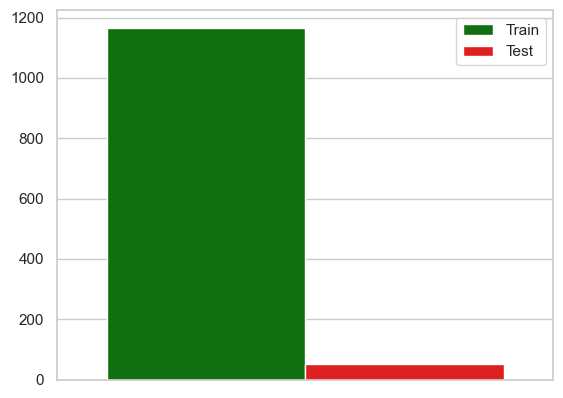

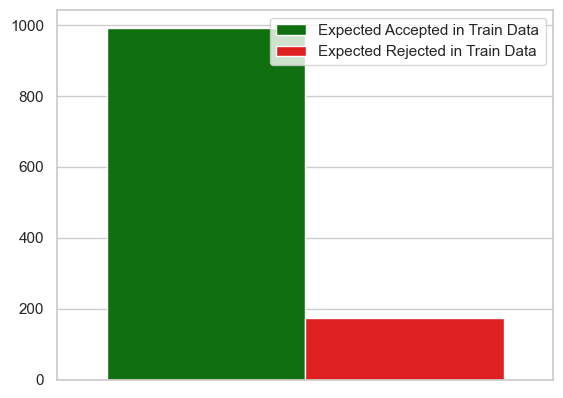

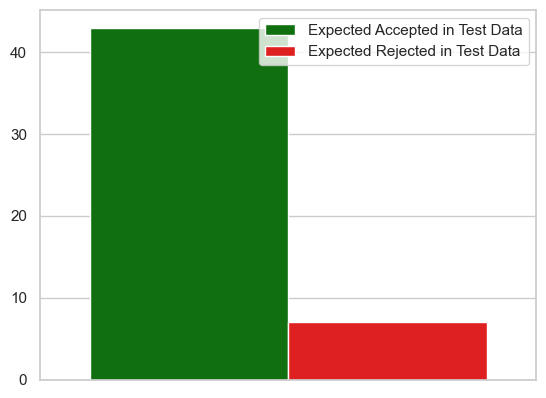

In [10]:
with open("../../data/training/train.json", "r", encoding="utf-8") as fp:
    train_reviews = json.load(fp)

with open("../../data/training/test.json", "r", encoding="utf-8") as fp:
    test_reviews = json.load(fp)


print(f"All Data: {len(train_reviews) + len(test_reviews)}")
print(f"Train Data: {len(train_reviews)}")
print(f"Test Data: {len(test_reviews)}")


sns.set_theme(style="whitegrid")

plt.figure()
sns.barplot(hue=["Train", "Test"], y=[len(train_reviews), len(test_reviews)], palette=["green", "red"])

plt.figure()
sns.barplot(hue=["Expected Accepted in Train Data", "Expected Rejected in Train Data"], y=[len([r for r in train_reviews if bool(r["conclusion"])]), len([r for r in train_reviews if not bool(r["conclusion"])])], palette=["green", "red"])

plt.figure()
sns.barplot(hue=["Expected Accepted in Test Data", "Expected Rejected in Test Data"], y=[len([r for r in test_reviews if bool(r["conclusion"])]), len([r for r in test_reviews if not bool(r["conclusion"])])], palette=["green", "red"])

In [11]:
def createDataFrame(file):
    ratings = [review['rating'] for review in file]
    conclusions = [review['conclusion'] for review in file]
    df = pd.DataFrame({'rating': ratings, 'conclusion': conclusions})

    ratingAttr = ['Accuracy', 'Objectivity', 'Clarity and Coherence', 'Depth of Analysis', 'Language and Presentation', 'Readability', 'Attractiveness']
    for i in range(7):
        df[ratingAttr[i]] = df['rating'].apply(lambda x: x[i])
    df.drop('rating', axis=1, inplace=True)
    return df

train_df = createDataFrame(train_reviews)
test_df = createDataFrame(test_reviews)

X_train = train_df.drop('conclusion', axis=1)
y_train = train_df['conclusion']
X_test = test_df.drop('conclusion', axis=1)
y_test = test_df['conclusion']

display(X_train.head(5))
display(y_train.head(5))

,Accuracy,Objectivity,Clarity and Coherence,Depth of Analysis,Language and Presentation,Readability,Attractiveness
0,3,3,4,4,5,4,3
1,7,8,7,6,9,8,8
2,5,7,6,4,7,6,6
3,7,5,8,6,7,8,7
4,7,7,8,6,8,7,6


0    0
1    1
2    1
3    1
4    1
Name: conclusion, dtype: int64

In [12]:
rf = RandomForestClassifier(n_estimators=50, random_state=42)
print("Training started")
rf.fit(X_train, y_train)
print("Training finished")

Training started
Training finished


In [13]:
y_pred = rf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(f"Test ROC AUC Score: {roc_auc_score(y_test, y_pred):.4f}")

Accuracy: 96.00%
Test ROC AUC Score: 0.9169


In [ ]:
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}
results = cross_validate(rf, X_train, y_train, cv=10, scoring=scoring)
print("Accuracy scores for each fold:", results['test_accuracy'])
print("Mean cross-validation accuracy:", results['test_accuracy'].mean())
print("Mean cross-validation precision:", results['test_precision'].mean())
print("Mean cross-validation recall:", results['test_recall'].mean())
print("Mean cross-validation F1 score:", results['test_f1_score'].mean())


Accuracy scores for each fold: [0.97435897 0.94871795 0.94017094 0.97435897 0.8974359  0.95726496
 0.97435897 0.98275862 0.93965517 0.92241379]
Mean cross-validation accuracy: 0.9511494252873562
Mean cross-validation precision: 0.9683447154044103
Mean cross-validation recall: 0.9748787878787878
Mean cross-validation F1 score: 0.9714022800108661


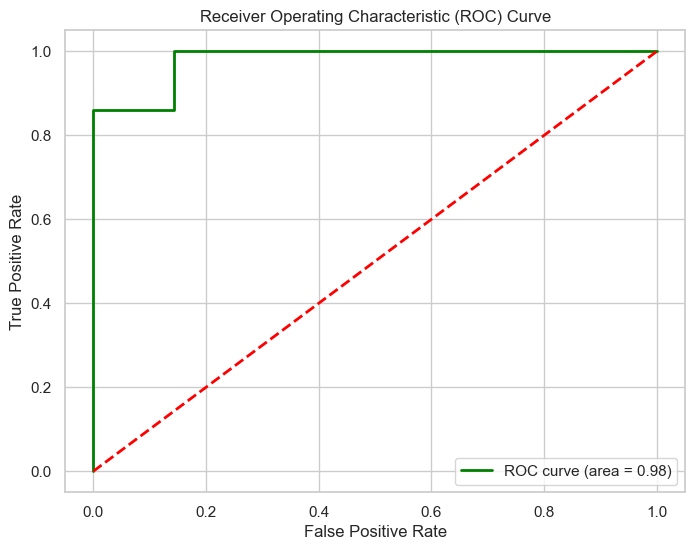

In [14]:
y_pred_prob = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [15]:
fi_model = pd.DataFrame({'feature': X_train.columns,
                   'importance': rf.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(7)

,feature,importance
0,Accuracy,0.311027
6,Attractiveness,0.198267
5,Readability,0.181165
2,Clarity and Coherence,0.149403
1,Objectivity,0.061084
3,Depth of Analysis,0.058693
4,Language and Presentation,0.040361


In [22]:
param_grid = {
    'n_estimators': [20, 30, 50, 100],
    'max_depth': [None, 3, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

estimator = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2, scoring='accuracy')
print("GridSearchCV started")
grid_search.fit(X_train, y_train)
print("GridSearchCV finished")

print("Best Parameters:", grid_search.best_params_)
print("Best Score (Accuracy):", grid_search.best_score_)

Cross Validation started
Fitting 10 folds for each of 432 candidates, totalling 4320 fits
Cross Validation finished
Best Parameters: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Best Score (Accuracy): 0.9648688476274685


In [18]:
best_rf = grid_search.best_estimator_

y_cv_pred = best_rf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_cv_pred) * 100:.2f}%")
print(f"Test ROC AUC Score: {roc_auc_score(y_test, y_cv_pred):.4f}")

Accuracy: 96.00%
Test ROC AUC Score: 0.9169


In [19]:
n_nodes = []
max_depths = []

for ind_tree in best_rf.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 40
Average maximum depth 5


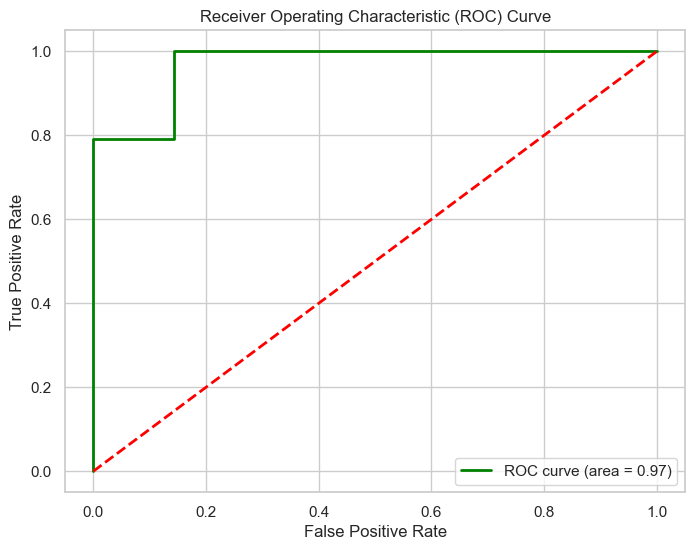

In [20]:
y_cv_pred_prob = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_cv_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [21]:
fi_cv_model = pd.DataFrame({'feature': X_train.columns,
                   'importance': best_rf.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_cv_model.head(7)

,feature,importance
0,Accuracy,0.305522
5,Readability,0.233099
2,Clarity and Coherence,0.197816
6,Attractiveness,0.151214
3,Depth of Analysis,0.053611
1,Objectivity,0.041439
4,Language and Presentation,0.017299


In [35]:
reduce_train_df = train_df.drop(['Accuracy', 'Readability'], axis=1)
display(reduce_train_df.head(5))
reduce_test_df = test_df.drop(['Accuracy', 'Readability'], axis=1)
X_train_reduce = reduce_train_df.drop('conclusion', axis=1)
y_train_reduce = reduce_train_df['conclusion']
X_test_reduce = reduce_test_df.drop('conclusion', axis=1)
y_test_reduce = reduce_test_df['conclusion']

,conclusion,Objectivity,Clarity and Coherence,Depth of Analysis,Language and Presentation,Attractiveness
0,0,3,4,4,5,3
1,1,8,7,6,9,8
2,1,7,6,4,7,6
3,1,5,8,6,7,7
4,1,7,8,6,8,6


In [30]:
rf_reduce = RandomForestClassifier(n_estimators=50, random_state=42)
print("Training started")
rf_reduce.fit(X_train_reduce, y_train_reduce)
print("Training finished")

Training started
Training finished


In [33]:
y_pred_reduce = rf_reduce.predict(X_test_reduce)
print(f"Accuracy: {accuracy_score(y_test_reduce, y_pred_reduce) * 100:.2f}%")
print(f"Test ROC AUC Score: {roc_auc_score(y_test_reduce, y_pred_reduce):.4f}")

Accuracy: 96.00%
Test ROC AUC Score: 0.9169


In [36]:
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}
results = cross_validate(rf_reduce, X_train_reduce, y_train_reduce, cv=10, scoring=scoring)
print("Accuracy scores for each fold:", results['test_accuracy'])
print("Mean cross-validation accuracy:", results['test_accuracy'].mean())
print("Mean cross-validation precision:", results['test_precision'].mean())
print("Mean cross-validation recall:", results['test_recall'].mean())
print("Mean cross-validation F1 score:", results['test_f1_score'].mean())

Accuracy scores for each fold: [0.94871795 0.94871795 0.94017094 0.96581197 0.92307692 0.94017094
 0.96581197 0.98275862 0.9137931  0.9137931 ]
Mean cross-validation accuracy: 0.944282346006484
Mean cross-validation precision: 0.9588062160498317
Mean cross-validation recall: 0.9768484848484847
Mean cross-validation F1 score: 0.9675956369606367


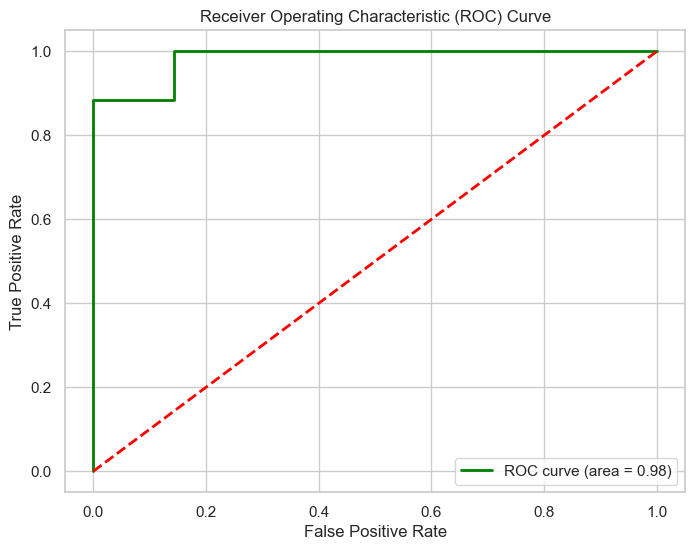

In [37]:
y_reduce_pred_prob = rf_reduce.predict_proba(X_test_reduce)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_reduce, y_reduce_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [38]:
fi_cv_model_reduce = pd.DataFrame({'feature': X_train_reduce.columns,
                   'importance': rf_reduce.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_cv_model_reduce.head(7)

,feature,importance
4,Attractiveness,0.332254
1,Clarity and Coherence,0.321637
2,Depth of Analysis,0.149295
0,Objectivity,0.145167
3,Language and Presentation,0.051647


In [ ]:
s